In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, Normalizer
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder


import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from xverse.transformer import WOE

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV

In [54]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [55]:
from src.models.predict_model import predict_proba_score, predict_proba_, plot_feature_importance, metrics
from src.data.location_notebook import get_location
import src.visualization.visualize as vz

In [56]:
(DATA_DIR, DATA_DIR_PROCESSED, 
INTERMEDIATE_RESULTS, GROUP_INTERMEDIATE_RESULTS, 
CLEANED_DS , TRAIN_RAW_FILE, 
VALIDATION_RAW_FILE, TEMPLATE_SUBMIT) = get_location()

In [57]:
df_train = pd.read_parquet(CLEANED_DS)
df_val = df_train[df_train.train==0]
df_train = df_train[df_train.train==1]

In [58]:
labels = pd.read_csv(os.path.join(DATA_DIR, TRAIN_RAW_FILE))[['Opportunity_ID', 'Stage']].drop_duplicates()
prod_cols = df_train.columns[df_train.columns.str.contains("Product_Name|Product_Family")]

In [59]:
labels = df_train[['Opportunity_ID']].merge(labels, how='left').Stage
y = labels == 'Closed Won'

X = df_train.drop(columns=["Opportunity_ID", "train"]).drop(columns=prod_cols)

In [60]:
clf = WOE()
clf.fit(X, y)

/home/jloscalzo/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


WOE(mono_custom_binning={'ASP_was_converted_False': array([0., 1.]),
                         'ASP_was_converted_True': array([0., 1.]),
                         'Account_Created_Date_Month': array([ 1.,  6.,  8., 12.]),
                         'Account_Created_Date_Period': array([201307., 201407., 201606., 201812.]),
                         'Account_Created_Date_Q1_Quarter': array([0., 1.]),
                         'Account_Created_Date_Q2_Quarter': array([0., 1.]),
                         'Account_Created_Date_Q3...
              'Bureaucratic_Code_Bureaucratic_Code_4': {0.0: -1.0278262629789312,
                                                        1.0: 0.31524203571448933},
              'Bureaucratic_Code_Bureaucratic_Code_5': {0.0: 0.2728814057914615,
                                                        1.0: -1.0743372385026175},
              'Bureaucratic_Code_Bureaucratic_Code_6': {0.0: -0.00019718032204284373,
                                                        

In [61]:
clf.woe_df#[clf.woe_df.Variable_Name.str.contains('Territory')]

Variable_Name      Category  Count   Event  \
0              ASP_was_converted_False             0   5047  2862.0   
1              ASP_was_converted_False             1   4794  2210.0   
2               ASP_was_converted_True             0   4794  2210.0   
3               ASP_was_converted_True             1   5047  2862.0   
4           Account_Created_Date_Month  (0.999, 6.0]   3981  1786.0   
..                                 ...           ...    ...     ...   
274  Total_Taxable_Amount_Currency_JPY             1   1605  1122.0   
275  Total_Taxable_Amount_Currency_USD             0   5056  2862.0   
276  Total_Taxable_Amount_Currency_USD             1   4785  2210.0   
277                       has_contract             0   4575   101.0   
278                       has_contract             1   5266  4971.0   

     Non_Event  Event_Rate  Non_Event_Rate  Event_Distribution  \
0       2185.0    0.567070        0.432930            0.564274   
1       2584.0    0.460993        0.539007            0.435726   
2       2584.0    0.460993        0.539007            0.435726   
3       2185.0    0.567070        0.432930            0.564274   
4       2195.0    0.448631        0.551369            0.352129   
..         ...         ...             ...                 ...   
274      483.0    0.699065        0.300935            0.221215   
275     2194.0    0.566060        0.433940            0.564274   
276     2575.0    0.461860        0.538140            0.435726   
277     4474.0    0.022077        0.977923            0.019913   
278      295.0    0.943980        0.056020            0.980087   

     Non_Event_Distribution       WOE  Information_Value  
0                  0.458167  0.208306           0.045228  
1                  0.541833 -0.217945           0.045228  
2                  0.541833 -0.217945           0.045228  
3                  0.458167  0.208306           0.045228  
4                  0.460264 -0.267802           0.050221  
..                      ...       ...                ...  
274                0.101279  0.781253           0.110879  
275                0.460055  0.204196           0.043632  
276                0.539945 -0.214456           0.043632  
277                0.938142 -3.852516           6.074377  
278                0.061858  2.762802           6.074377  

[279 rows x 11 columns]

Con el information value podemos ver que has_contract tiene un poder preditivo "dudoso". Sabemos que la competencia tiene data-leakage.

In [62]:
iv_features = clf.iv_df[lambda d: d.Information_Value>.1]
print(iv_features)

                             Variable_Name  Information_Value
124                           has_contract           6.074377
105                                    TRF           0.700504
84                 Planned_Range_days_mean           0.513069
116               Total_Amount_Opportunity           0.459438
26   Bureaucratic_Code_Bureaucratic_Code_4           0.315608
108     Total_Amount_Converted_Opportunity           0.301936
27   Bureaucratic_Code_Bureaucratic_Code_5           0.286279
99                        Quote_Range_days           0.281703
10             Account_Type_Account_Type_0           0.244984
20            Bureaucratic_Code_0_Approval           0.198097
117                   Total_Taxable_Amount           0.190663
91          Quote_Expiry_Date_Imputed_True           0.154761
90         Quote_Expiry_Date_Imputed_False           0.154761
14             Account_Type_Account_Type_5           0.139953
8                Account_Created_Date_Year           0.138869
3       

In [63]:
iv_features = iv_features.Variable_Name.values
X = X[iv_features]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [65]:
param_test = {
    'num_leaves': sp_randint(6, 50), 
    'min_child_samples': sp_randint(100, 500), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.2, scale=0.8), 
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

fit_params = {
    "eval_set":[(X_test, y_test),(X_train, y_train)], 
    'eval_names':["test", "train"],
    "early_stopping_rounds":25,
    #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
    'categorical_feature': 'auto'
}

In [66]:
clf = LGBMClassifier(n_estimators=4000, learning_rate=0.005)
gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=10,
    scoring='neg_log_loss',
    cv=3,
    refit=True,
    random_state=42,
    verbose=True
)

In [ ]:
# gs.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[1]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
Training until validation scores don't improve for 25 rounds.
[2]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[3]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[4]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[5]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[6]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[7]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[8]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[9]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[10]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[11]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[12]	test's binary_logloss: 0.693117	train's binary_logloss: 0.693131
[13]	test's binary_logloss: 0.693117	train's b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training until validation scores don't improve for 25 rounds.
[2]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[3]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[4]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[5]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[6]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[7]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[8]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[9]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[10]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[11]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[12]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[13]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[14]	test's binary_logloss: 0.69314	train's binary_logloss: 0.693154
[15]	test's binary_logloss: 0.69314	train's bina

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 14.6min finished


[10]	test's binary_logloss: 0.654811	train's binary_logloss: 0.655721
[11]	test's binary_logloss: 0.650979	train's binary_logloss: 0.65198
[12]	test's binary_logloss: 0.647183	train's binary_logloss: 0.648273
[13]	test's binary_logloss: 0.643422	train's binary_logloss: 0.644602
[14]	test's binary_logloss: 0.639696	train's binary_logloss: 0.640965
[15]	test's binary_logloss: 0.636005	train's binary_logloss: 0.637361
[16]	test's binary_logloss: 0.632347	train's binary_logloss: 0.633792
[17]	test's binary_logloss: 0.628723	train's binary_logloss: 0.630255
[18]	test's binary_logloss: 0.625132	train's binary_logloss: 0.626751
[19]	test's binary_logloss: 0.621574	train's binary_logloss: 0.62328
[20]	test's binary_logloss: 0.620154	train's binary_logloss: 0.621924
[21]	test's binary_logloss: 0.61664	train's binary_logloss: 0.618495
[22]	test's binary_logloss: 0.615271	train's binary_logloss: 0.6172
[23]	test's binary_logloss: 0.6118	train's binary_logloss: 0.613814
[24]	test's binary_logloss:

In [71]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: -0.13674649041562206 with params: {'colsample_bytree': 0.9053708647569991, 'min_child_samples': 143, 'min_child_weight': 0.001, 'num_leaves': 15, 'reg_alpha': 2, 'reg_lambda': 20, 'subsample': 0.7818175966851368} 


In [180]:
best_params = {
    'colsample_bytree': 0.90,
    'min_child_samples': 143,
    'min_child_weight': 0.001,
    'num_leaves': 15,
    'reg_alpha': 2,
    'reg_lambda': 20,
    'subsample': 0.7818175966851368
}

In [183]:
def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 3e-3 else 3e-3

In [152]:
scores_lgb = cross_validate(
    LGBMClassifier(n_estimators=4000, learning_rate=0.005, **best_params), 
    X_train, y_train, 
    fit_params={
        "eval_set":[(X_test, y_test),(X_train, y_train)], 
        'eval_names':["test", "train"],
        "early_stopping_rounds":30,
#         "callbacks":[lgb.reset_parameter(learning_rate=learning_rate_005_decay_power_099)]
    },
    cv=3, scoring='neg_log_loss', 
    return_estimator=True, return_train_score=True
)

[1]	test's binary_logloss: 0.688518	train's binary_logloss: 0.68862
Training until validation scores don't improve for 30 rounds.
[2]	test's binary_logloss: 0.684409	train's binary_logloss: 0.684604
[3]	test's binary_logloss: 0.680339	train's binary_logloss: 0.680627
[4]	test's binary_logloss: 0.676308	train's binary_logloss: 0.676688
[5]	test's binary_logloss: 0.672315	train's binary_logloss: 0.672788
[6]	test's binary_logloss: 0.66836	train's binary_logloss: 0.668924
[7]	test's binary_logloss: 0.664442	train's binary_logloss: 0.665097
[8]	test's binary_logloss: 0.66056	train's binary_logloss: 0.661306
[9]	test's binary_logloss: 0.656715	train's binary_logloss: 0.657551
[10]	test's binary_logloss: 0.655233	train's binary_logloss: 0.656168
[11]	test's binary_logloss: 0.651436	train's binary_logloss: 0.652461
[12]	test's binary_logloss: 0.647675	train's binary_logloss: 0.648788
[13]	test's binary_logloss: 0.643948	train's binary_logloss: 0.645149
[14]	test's binary_logloss: 0.640255	tra

In [153]:
pd.DataFrame(scores_lgb)

fit_time  score_time                                          estimator  \
0  20.689658    0.493936  LGBMClassifier(colsample_bytree=0.9, learning_...   
1  29.900728    0.400590  LGBMClassifier(colsample_bytree=0.9, learning_...   
2  44.327991    0.502031  LGBMClassifier(colsample_bytree=0.9, learning_...   

   test_score  train_score  
0   -0.140517    -0.098291  
1   -0.132038    -0.106624  
2   -0.137685    -0.101936

In [154]:
plot_feature_importance(np.array([est.feature_importances_ for est in scores_lgb["estimator"]]).mean(axis=0), iv_features)

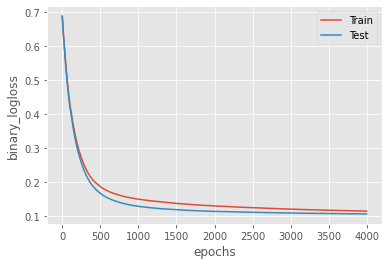

In [155]:
vz.plot_learning_curve(scores_lgb["estimator"][2].evals_result_)

In [156]:
metrics(scores_lgb["estimator"][2], X_test, y_test)

0.10552478893855571

In [186]:
model = LGBMClassifier(n_estimators=6000, learning_rate=0.5, is_unbalance=True, **best_params)

model.fit( 
    X_train, y_train, 
    eval_set=[(X_train, y_train),(X_test, y_test)], 
    eval_names=["train", "test"],
#     early_stopping_rounds=25
    callbacks = [lgb.reset_parameter(learning_rate=learning_rate_005_decay_power_099)]
)


[1]	train's binary_logloss: 0.652678	test's binary_logloss: 0.651725
[2]	train's binary_logloss: 0.616794	test's binary_logloss: 0.614954
[3]	train's binary_logloss: 0.584444	test's binary_logloss: 0.581768
[4]	train's binary_logloss: 0.555156	test's binary_logloss: 0.55169
[5]	train's binary_logloss: 0.528545	test's binary_logloss: 0.524329
[6]	train's binary_logloss: 0.504286	test's binary_logloss: 0.499356
[7]	train's binary_logloss: 0.482108	test's binary_logloss: 0.476497
[8]	train's binary_logloss: 0.461779	test's binary_logloss: 0.455517
[9]	train's binary_logloss: 0.443093	test's binary_logloss: 0.436236
[10]	train's binary_logloss: 0.436017	test's binary_logloss: 0.42882
[11]	train's binary_logloss: 0.419418	test's binary_logloss: 0.411652
[12]	train's binary_logloss: 0.404077	test's binary_logloss: 0.395794
[13]	train's binary_logloss: 0.389882	test's binary_logloss: 0.381104
[14]	train's binary_logloss: 0.376725	test's binary_logloss: 0.367473
[15]	train's binary_logloss: 0.

LGBMClassifier(colsample_bytree=0.9, is_unbalance=True, learning_rate=0.5,
               min_child_samples=143, n_estimators=6000, num_leaves=15,
               reg_alpha=2, reg_lambda=20, subsample=0.7818175966851368)

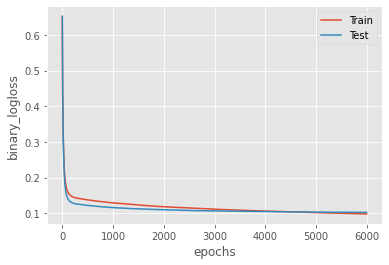

In [187]:
vz.plot_learning_curve(model.evals_result_)

In [188]:
metrics(model, X_test, y_test)

0.10243465652168195

## Predictions
### pred with 1 model

In [192]:
model = LGBMClassifier(n_estimators=6000, learning_rate=0.5, is_unbalance=True, **best_params)

model.fit( 
    X, y, 
    eval_set=[(X_train, y_train),(X_test, y_test)], 
    eval_names=["train", "test"],
#     early_stopping_rounds=25
    callbacks = [lgb.reset_parameter(learning_rate=learning_rate_005_decay_power_099)]
)

[1]	train's binary_logloss: 0.652348	test's binary_logloss: 0.651387
[2]	train's binary_logloss: 0.616188	test's binary_logloss: 0.614333
[3]	train's binary_logloss: 0.583607	test's binary_logloss: 0.580908
[4]	train's binary_logloss: 0.554124	test's binary_logloss: 0.550627
[5]	train's binary_logloss: 0.527346	test's binary_logloss: 0.523093
[6]	train's binary_logloss: 0.502946	test's binary_logloss: 0.497971
[7]	train's binary_logloss: 0.480646	test's binary_logloss: 0.474984
[8]	train's binary_logloss: 0.460214	test's binary_logloss: 0.453894
[9]	train's binary_logloss: 0.441448	test's binary_logloss: 0.434497
[10]	train's binary_logloss: 0.43416	test's binary_logloss: 0.426511
[11]	train's binary_logloss: 0.417515	test's binary_logloss: 0.409298
[12]	train's binary_logloss: 0.402139	test's binary_logloss: 0.393406
[13]	train's binary_logloss: 0.387923	test's binary_logloss: 0.378663
[14]	train's binary_logloss: 0.374742	test's binary_logloss: 0.365007
[15]	train's binary_logloss: 0

LGBMClassifier(colsample_bytree=0.9, is_unbalance=True, learning_rate=0.5,
               min_child_samples=143, n_estimators=6000, num_leaves=15,
               reg_alpha=2, reg_lambda=20, subsample=0.7818175966851368)

In [193]:
def save_prediction_file(ids):
    from datetime import datetime
    now = datetime.now().strftime("%Y%m%d_%H%M")
    prediction_file = f'../data/results/lg_submit_{now}.csv'
    ids = ids.groupby("Opportunity_ID")["proba1"].mean().reset_index()
    ids.Opportunity_ID = ids.Opportunity_ID.astype('int')
    ids[["Opportunity_ID", "proba1"]].to_csv(prediction_file, header=None, index=None)
    

In [194]:
features_val = df_val[iv_features]#.drop(columns=prod_cols)

In [195]:
answers = model.predict_proba(features_val)[:,-1]
ids.loc[:, "proba1"] = answers
save_prediction_file(ids)


### Pred with cv models

In [196]:
answers = predict_proba_(scores_lgb["estimator"], features_val)

In [197]:
ids = df_val[["Opportunity_ID"]]

In [198]:
ids.loc[:, "proba1"] = answers

In [199]:
ids.head()

Opportunity_ID    proba1
9841         10689.0  0.974035
9842         10690.0  0.961092
9843         10691.0  0.910343
9844         10692.0  0.799562
9845         10693.0  0.908000

In [200]:
save_prediction_file(ids)